# 1. Import libraries

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Find the best paramaters for RF model then train RF model
1. n_estimators
2. max_depth
3. min_samples_split

In [2]:
# Load Data
df = pd.read_csv("0_dfu_features.csv")
X = df.drop('ulcer_present', axis=1)
y = df['ulcer_present']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Optimization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Set the optimized model as your main model
best_rf = grid_search.best_estimator_
print(f"✅ Best Parameters Found: {grid_search.best_params_}")

✅ Best Parameters Found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


# 3. Validation and Export to CSV

In [3]:
# INTERNAL VALIDATION (Test Set)
y_pred = best_rf.predict(X_test)
print(f"Internal Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# EXPORT AUDIT LOG (CSV)
audit_df = X_test.copy()
audit_df['Actual_Label'] = y_test.values
audit_df['Predicted_Label'] = y_pred
audit_df['Is_Correct'] = audit_df['Actual_Label'] == audit_df['Predicted_Label']
audit_df.to_csv("2_RF_Audit_Report.csv", index=False)

Internal Test Accuracy: 0.94

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       101
           1       0.95      0.93      0.94       110

    accuracy                           0.94       211
   macro avg       0.94      0.94      0.94       211
weighted avg       0.94      0.94      0.94       211



# 4. Confusion Matrix Visualization

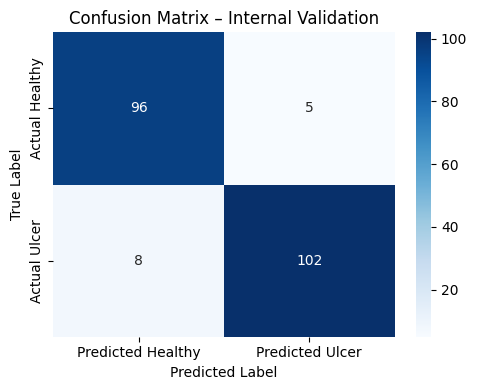

In [4]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Healthy", "Predicted Ulcer"],
    yticklabels=["Actual Healthy", "Actual Ulcer"]
)
plt.title("Confusion Matrix – Internal Validation")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 5. EXTERNAL VALIDATION 
1. Using testset from kaggle to validate again
2. Only compromise of ulcer pictures. No healthy pictures

In [5]:
try:
    df_external = pd.read_csv("1_dfu_features_testset.csv")
    X_ext = df_external.drop('ulcer_present', axis=1)
    y_ext = df_external['ulcer_present']
    y_ext_pred = best_rf.predict(X_ext)
    print(f"External Validation Accuracy: {accuracy_score(y_ext, y_ext_pred):.2f}")
except FileNotFoundError:
    print("\nNote: External CSV not found.")

External Validation Accuracy: 0.93


# 6. ROC and AUC

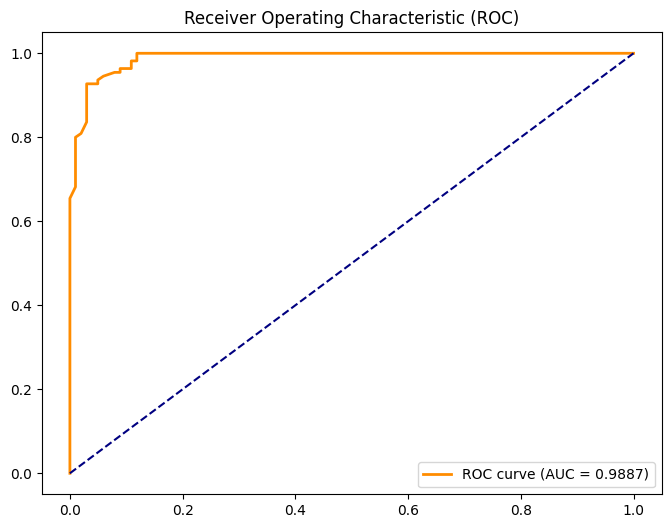

In [6]:
y_probs = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 7. FEATURE IMPORTANCE VISUALIZATION

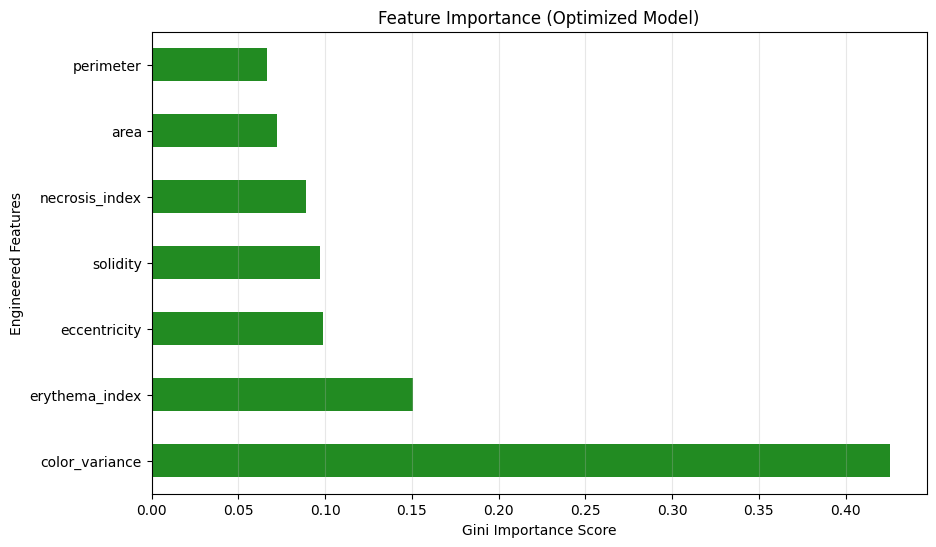

💡 Top Diagnostic Driver: color_variance


In [7]:
importances = best_rf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feat_importance.plot(kind='barh', color='forestgreen')
plt.title("Feature Importance (Optimized Model)")
plt.xlabel("Gini Importance Score")
plt.ylabel("Engineered Features")
plt.grid(axis='x', alpha=0.3)
plt.show()

print("💡 Top Diagnostic Driver:", feat_importance.index[0])